Math 485 Spring 2019 Prof Lega
Supermodel Group

Created by: Alex Stoken 18 Feb 2019

Last updated: 26 Feb 2019

This file takes input data and returns the minimum connection coefficient vector C

# TODO
* [DONE] make (F,C) output a csv so that it's ready to be read in again
* add docstrings
* increase efficiency
* [DONE] wrap the animation routine in a function
* [DONE] use a random C vector to start to find other local minima
* write a routine to increase K over time

In [134]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pickle
import datetime
%matplotlib inline

In [133]:
def load_lorentz_data(fname):
    """
    loads data from xlsx file, returns np.array()
    """
    data = pd.read_excel(fname, names=['x','y','z'])
    return np.array(data)
x_o = load_lorentz_data('TrueValues_SuperModel.xlsx')

In [60]:
def cost_fn(C, K =200, gamma= 0.4, delta =1, fname= None, data = None):
    """
    
    """      
    t = np.arange(0,1000,0.01)
    #take the integral of the lorentz system with the given Cs
    sum_k = 0
    for i in range(K): 
        
        #sum_k = integrate.quad(integrand,t[i], t[i]+delta,args = (data, C, t,i,0.4))[0]
        sol = integrate.odeint(conn_lorentz, x_init, t, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
        s_model = supermodel(sol)
        integrand = 0
        for j in range(100):
            model = s_model[i + j]
            truth = data[i+j,0:3]
            diff = model - truth 
            integrand += np.linalg.norm(diff)**2 * (gamma**t[i+j]) 
            
        sum_k += integrand
    
    norm = 1/ (K * delta)
    F = sum_k * norm
    with open(fname,'a') as f:    
        C_str = str(C_test.tolist())
        C_to_file = C_str.strip('[]')
        f.write(str(F) + ',' + C_to_file +',' + '\n')
    print(F, C)
    return F

def integrand(t, data, C, t_large,i,gamma= 0.4):
    """
    
    """
    sol = integrate.odeint(conn_lorentz, x_init, t_large, args=(C,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))
    s_model = supermodel(sol)
    model = s_model[i]
    truth = data[i,0:3]
    diff = model - truth 
    
    return np.linalg.norm(diff)**2 * (gamma**t) 

def conn_lorentz(x_vect, t0,C, sig = [10,10,10], rho = [28,28,28], beta = [8 /3,8/3,8/3]):
    """
    Parameters:
    sigma, rho, beta - model parameters from climate data

    
    Returns: 
    l vector for next timestep 
    """
    x1,y1,z1, x2, y2, z2, x3, y3, z3 = x_vect
    
    cx12, cx13, cx23, cx21, cx31, cx32, \
    cy12, cy13, cy23, cy21, cy31, cy32, \
    cz12, cz13, cz23, cz21, cz31, cz32 = C
    
    C_x1 = cx12 * (x2 - x1) + cx13 * (x3-x1)
    C_x2 = cx21 * (x1 - x2) + cx23 * (x3-x2)
    C_x3 = cx31 * (x1 - x3) + cx32 * (x2-x3)

    C_y1 = cy12 * (y2 - y1) + cy13 * (y3-y1)
    C_y2 = cy21 * (y1 - y2) + cy23 * (y3-y2)
    C_y3 = cy31 * (y1 - y3) + cy32 * (y2-y3)
    
    C_z1 = cz12 * (z2 - z1) + cz13 * (z3-z1)
    C_z2 = cz21 * (z1 - z2) + cz23 * (z3-z2)
    C_z3 = cz31 * (z1 - z3) + cz32 * (z2-z3)
    
    sig1,sig2,sig3 = sig
    rho1,rho2,rho3 = rho
    beta1,beta2,beta3 = beta
    
    dx1 = sig1 * (y1-x1) + C_x1
    dy1 = x1 * (rho1 - z1) -y1 + C_y1
    dz1 = x1 * y1 - beta1 *z1 +C_z1

    dx2 = sig2 * (y2-x2) + C_x2
    dy2 = x2 * (rho2  -z2) - y2 + C_y2
    dz2 = x2 * y2 - beta2 *z2 +C_z2

    dx3 = sig3 * (y3-x3) + C_x3
    dy3 = x3 * (rho3 - z3) - y3 + C_y3
    dz3 = x3 * y3 - beta3 *z3 +C_z3
    
    
    return [dx1,dy1,dz1,dx2,dy2,dz2,dx3,dy3,dz3]

def supermodel(sol):
    """
    input is three 3-vectors of model solns
    
    returns 3 vector of supermodel solns
    """
    x_s = 1/3 * (sol[:,0:3] + sol[:,3:6] + sol[:,6:9])
    return x_s

In [124]:
def run_sm_optimization(last_fname = None):
    """
    
    """
    #set parameter values
    gamma = 0.4
    delta = 1
    K = 10


    #load data and set initial conditions
    x_o = load_lorentz_data('TrueValues_SuperModel.xlsx', )
    x_init = [x_o[0,i] for i in range(3) for i in range(3)]
    
    
    
    C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 

    
    if last_fname != None:
        F_C_df = pd.read_csv(last_fname, header = None,index_col = False, names = C_headers)
        C_opt_guess = np.array(F_C_df.iloc[-1])[1:]
    else:
        C_opt_guess = 10*np.random.random(18)

        
        
    #find true values for comparison
    truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
    data = truth[:, 0:3]
    

    #prepare optimization
    fname = 'F_list_' + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + '.csv'
    f = open(fname, 'w+')
    f.close()
    
    print(f'SM optimization beginning with C = {C_opt_guess}')
    C = optimize.fmin_cg(cost_fn, C_opt_guess, args=(K,gamma,delta, fname, data), full_output=True)

    print(C)
    print('SM has been optimized')

run_sm_optimization()

SM optimization beginning with C = [8.69900191 0.4425177  7.51928993 0.13014469 1.05953266 3.64458147
 5.33996187 0.50489676 9.58748352 3.31885039 0.76565626 4.64346089
 4.85668622 3.79072958 6.58725834 0.40640113 1.09407482 6.32456414]
2006.7658629763505 [8.69900191 0.4425177  7.51928993 0.13014469 1.05953266 3.64458147
 5.33996187 0.50489676 9.58748352 3.31885039 0.76565626 4.64346089
 4.85668622 3.79072958 6.58725834 0.40640113 1.09407482 6.32456414]
2006.765863131706 [8.69900193 0.4425177  7.51928993 0.13014469 1.05953266 3.64458147
 5.33996187 0.50489676 9.58748352 3.31885039 0.76565626 4.64346089
 4.85668622 3.79072958 6.58725834 0.40640113 1.09407482 6.32456414]
2006.7658627233168 [8.69900191 0.44251772 7.51928993 0.13014469 1.05953266 3.64458147
 5.33996187 0.50489676 9.58748352 3.31885039 0.76565626 4.64346089
 4.85668622 3.79072958 6.58725834 0.40640113 1.09407482 6.32456414]
2006.7658621497349 [8.69900191 0.4425177  7.51928994 0.13014469 1.05953266 3.64458147
 5.33996187 0.5

KeyboardInterrupt: 

# VISUALIZE SUPERMODEL VS DATA (ANIMATION)

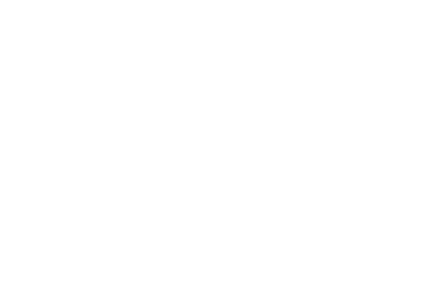

In [20]:
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

def make_ani(x_s, data, mp4_name = None):
    """
    makes the animation easy, just provide super model and truth 
    """
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')


    colors = ['blue','yellow']

    lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])

    x_t = np.asarray([x_s, data])
    
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    n=200

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=30, blit=True)
    
    ani.save(mp4name, writer = 'ffmpeg' )
    return ani


def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

def animate(i):
    i = (2 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts


In [21]:
ani.save('lorentz_sm.mp4', writer = 'ffmpeg')

# IGNORE BELOW THIS (PLAY AREA)

In [126]:
truth = integrate.odeint(conn_lorentz, x_init, t, args=(C_zeros,[10,10,10], [28,28,28],[8/3, 8/3, 8/3]))
data = truth[:,0:3]


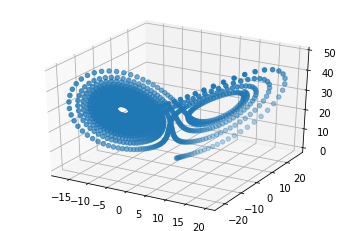

In [5]:
ax = plt.axes(projection='3d')
ax.scatter(x_o[:,0],x_o[:,1],x_o[:,2])

In [130]:
t = np.arange(0,1000,0.01)
C_opt_guess = np.zeros(18)
C_init = np.ones(18)

x_init = [x_o[0,i] for i in range(3) for i in range(3)]

out = integrate.odeint(conn_lorentz, x_init, t, args=(C_init,[13.25,7,6.5], [19,18,38],[3.5, 3.7, 1.7]))

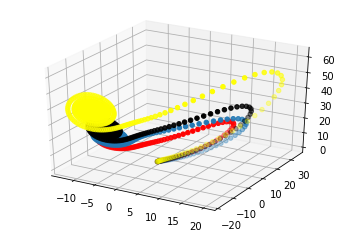

In [131]:
ax = plt.axes(projection='3d')
ax.scatter(out[:2000,0],out[:2000,1],out[:2000,2])
ax.scatter(out[:2000,3],out[:2000,4],out[:2000,5], c='red')
ax.scatter(out[:2000,6],out[:2000,7],out[:2000,8],c='yellow')
x_s = supermodel(out )
ax.scatter(x_s[:,0], x_s[:,1],x_s[:,2] ,c='black')

In [129]:
x_s[:,0:3]

array([[ 1.01256719,  1.2599178 ,  0.98489097],
       [ 1.0428809 ,  1.49260267,  0.97006726],
       [ 1.08913873,  1.73228921,  0.95875635],
       ...,
       [-7.82382831, -7.89702678, 24.09005143],
       [-7.82382831, -7.89702678, 24.09005143],
       [-7.82382831, -7.89702678, 24.09005143]])

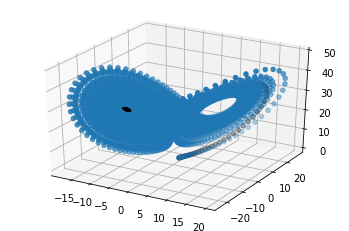

In [132]:
import mpld3
ax = plt.axes(projection='3d')
n=5000
#ax.scatter(out[:n,0],out[:n,1],out[:n,2], c = 'blue')
#ax.scatter(out[:n,3],out[:n,4],out[:n,5], c='red')
#ax.scatter(out[:n,6],out[:n,7],out[:n,8],c='yellow')
ax.scatter(truth[:n,6],truth[:n,7],truth[:n,8])
x_s = supermodel(out )
ax.scatter(x_s[:n,0], x_s[:n,1],x_s[:n,2] ,c='black')


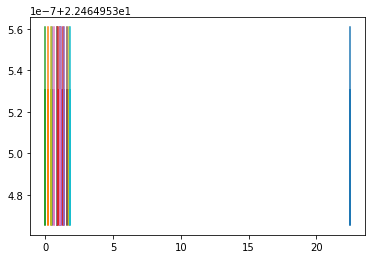

In [110]:
C_headers = ['F','cx12', 'cx13', 'cx23', 'cx21', 'cx31', 'cx32','cy12', 'cy13', 'cy23', 'cy21', 'cy31', 'cy32', 'cz12', 'cz13', 'cz23', 'cz21', 'cz31', 'cz32'] 
F_C_df = pd.read_csv('F_list_2019-02-26_21:15:12.csv', header = None,index_col = False, names = C_headers)
C_last = np.array(F_C_df.iloc[-1])[1:]
for c in F_C_df.columns:
    plt.plot( F_C_df[c], F_C_df['F'])